## Product-TimeSeries-AnalysisandPredictions-for-MarketSegmentations
Aim: to identify and predict frequent interesting customers for market segment
Data Source: IBM datasets: WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv

- Systmes and libraries setup
- Data Load
- Exploratory Analysis
  - product and customer analysis
- Time Series Analysis and Autoregressive predictions
  - 
- Performance Testing

In [142]:
# Systems and libraries setup

# import data structure libaries
import pandas as pd
import numpy as np

# import statistical and hypothesis testing libraries
from scipy import stats
import scipy.stats

# import visualisations libraries
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

#set fiqure size to control all plt plottings
plt.rcParams['figure.figsize']=(10,7)


In [143]:
#Data Load  

r_df = pd.read_csv('online_retail_II.csv') # make skip row =0 so that you can see the headlines
r_df = r_df.dropna()
print(r_df.shape)
r_df.head(2)   # print sample frame by rows



(824364, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


## Exploratory Analysis
- to check product distributions
- to 

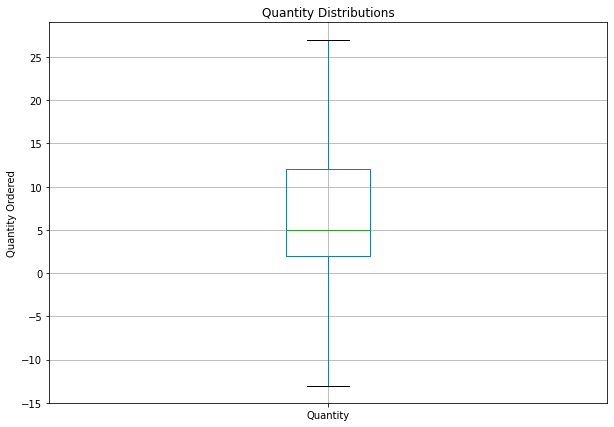

In [144]:
# checking the distributions of quantity

ax = r_df[['Quantity']].boxplot(
    showfliers = False, figsize = (10,7)
    )

ax.set_ylabel('Quantity Ordered')
ax.set_title('Quantity Distributions')

plt.show()

# explanation:
# existence of negative orders




plt.show()

(805620, 8)
(824364, 8)


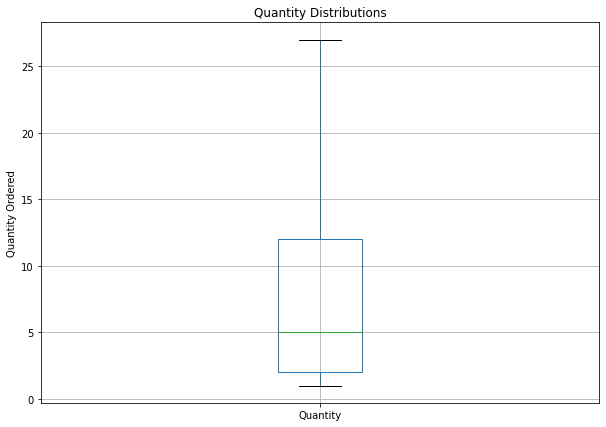

In [145]:
# filtering of negative orders

# filtering
r_df1 =r_df.loc[r_df['Quantity'] > 0]
print(r_df1.shape)   # filtered df
print(r_df.shape)    # original df

# visualisations
ax = r_df1[['Quantity']].boxplot(
    showfliers = False, figsize = (10,7)
    )

ax.set_ylabel('Quantity Ordered')
ax.set_title('Quantity Distributions')

plt.show()

# explanation:
# negative orders removed
# now the orders are now drop to 805620 request

 ## Time Series Analysis
 - understanding the trend of purchase using time series

InvoiceDate
2009-12-31    1512
2010-01-31    1011
Freq: M, Name: Invoice, dtype: int64


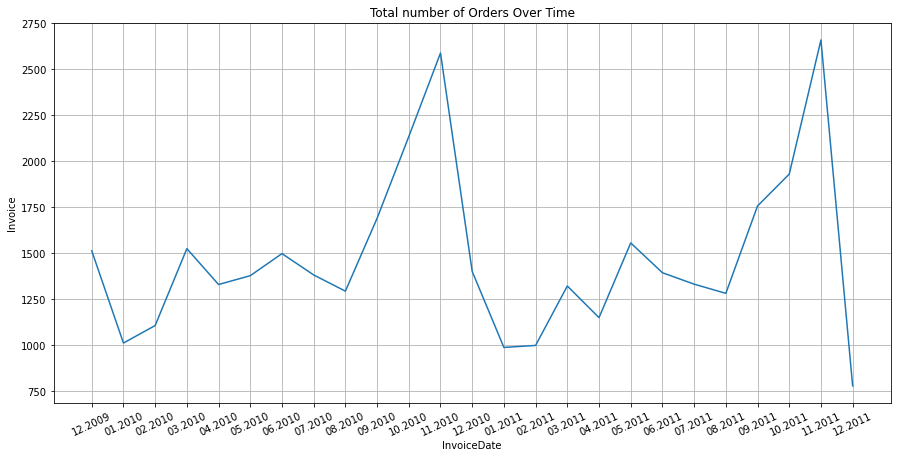

In [180]:
# understanding the trend of purchase using time series

# convert to datetime
# date object conversions from unknown type to datetime format
r_df1.loc[:,'InvoiceDate'] = pd.to_datetime(r_df1['InvoiceDate'])


# first convert date to month to see unique purchase 
orders_df_by_months = r_df1.set_index('InvoiceDate')['Invoice'].resample('M').nunique()
print(orders_df_by_months.head(2))


# visualisation
ax = pd.DataFrame(orders_df_by_months.values).plot(
    grid = True, 
    figsize = (15,7),
    legend = False
)

ax.set_xlabel('InvoiceDate')
ax.set_ylabel('Invoice')
ax.set_title('Total number of Orders Over Time')

plt.xticks(
    range(len(orders_df_by_months.index)),
    [x.strftime('%m.%Y') for x in orders_df_by_months.index],
    rotation = 25   # x labels position
)

plt.show()


In [172]:
# looking at the date with drop in quantities

inv_date = r_df1.loc[
    r_df1['InvoiceDate'] >= '2009-12-01', 'InvoiceDate'
]
print('Min date: %s\nMax date: %s' % (inv_date.min(), inv_date.max()))

Min date: 2009-12-01 07:45:00
Max date: 2011-12-09 12:50:00


In [230]:
# customers trend over time by invoice

# introduce sales to see customers response
r_df1.loc[:,'Sales'] = r_df1['Quantity'] * r_df1['Price']

# first aggregate by repeated invoice
customer_by_inv_df= r_df1.groupby(
    by= ['Invoice', 'InvoiceDate']
).agg(
    {'Sales': sum,
    'Customer ID': max,
    'Country':max}
).reset_index()

customer_by_inv_df.head(5)

# repeated customers by months
repeat_cust_by_months_df = customer_by_inv_df.set_index('InvoiceDate').groupby([
   pd.Grouper(freq='M'),'Customer ID']).filter(lambda x: len(x) >1).resample('M').nunique()['Customer ID']
print(repeat_cust_by_months_df.head(3))

# unique customers by months
unique_cust_by_months_df.loc[:,] = r_df1.set_index('InvoiceDate')['Customer ID'].resample('M').nunique()
print(unique_cust_by_months_df.head(3))


InvoiceDate
2009-12-31    286
2010-01-31    148
2010-02-28    175
Freq: M, Name: Customer ID, dtype: int64
InvoiceDate
2009-12-31    955
2010-01-31    720
2010-02-28    774
Freq: M, Name: Customer ID, dtype: int64


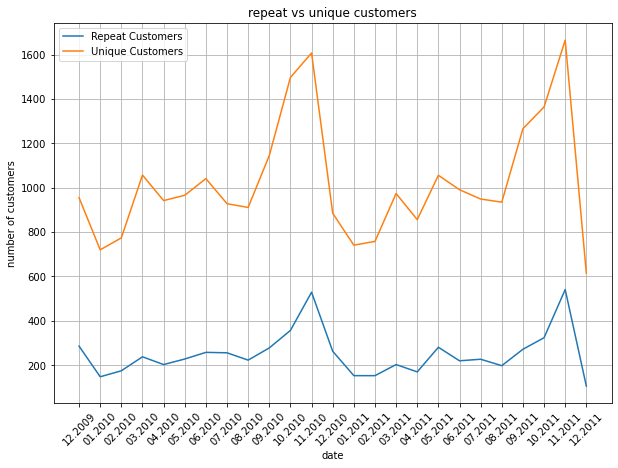

In [186]:
# visualisations of Repeat vs Unique Customers
ax = pd.DataFrame(repeat_cust_by_months_df.values).plot(
    figsize = (10,7)
)

pd.DataFrame(unique_cust_by_months_df.values).plot(
    ax = ax, grid = True
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('repeat vs unique customers')

ax.legend(['Repeat Customers', 'Unique Customers'])

plt.xticks(
    range(len(repeat_cust_by_months_df.index)),
    [x.strftime('%m.%Y') for x in repeat_cust_by_months_df.index],
    rotation = 45
)

plt.show()



## Time Series Analysis
- Analysis using unique customers for number of 

In [238]:
# unique customers by months
repeat_cust_by_months_df1 = pd.DataFrame(unique_cust_by_months_df)
#repeat_cust_by_months_df1 = repeat_cust_by_months_df1.rename(columns= { 1: 'Repeat'})
repeat_cust_by_months_df1.head(3)

,Customer ID
InvoiceDate,
2009-12-31,955
2010-01-31,720
2010-02-28,774


(25, 1)

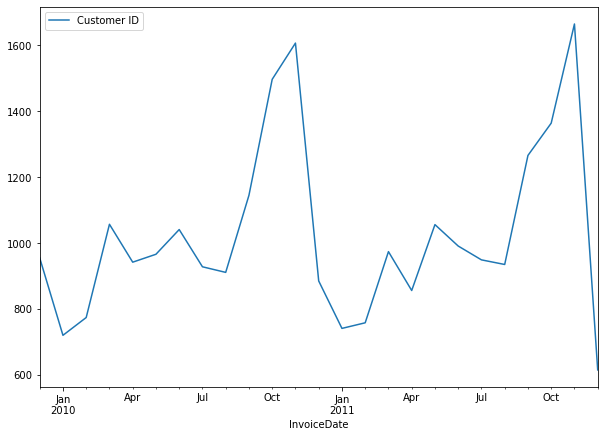

In [312]:
# examing the time series plot to check for stationarity, seasonlity, cyclicity

repeat_cust_by_months_df1.plot()
repeat_cust_by_months_df1.shape

In [297]:
# Further proof of stationarity at 0.05 confidence interval
# ADF is a unit root test for stationarity of a time series
# H0: there is a unit root
# H1: there is no unit root

from statsmodels.tsa.stattools import adfuller

ar_lag = adfuller(repeat_cust_by_months_df1['Customer ID'], autolag = 'BIC')
print(ar_lag)


# output explanation
# - since p-value is less than 0.05, the null hypothesis is rejected
# - similarily, the existence of strong negative values of the critical values also shows a rejected of hypothesis
# - hence, there is a stationarity with the sale's trend

(-3.722393502508871, 0.0038089709727327104, 9, 15, {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}, 210.0123713068457)


In [319]:
#create train and test data

start_date = '2009-12-01'
end_date = '2011-04-01'
train_data = repeat_cust_by_months_df1[start_date: end_date ]

test_start_date = '2011-03-01'
test_end_date = '2011-12-01'
train_data = repeat_cust_by_months_df1[test_start_date: test_end_date]

train_data.shape
#test_start_date

(9, 1)

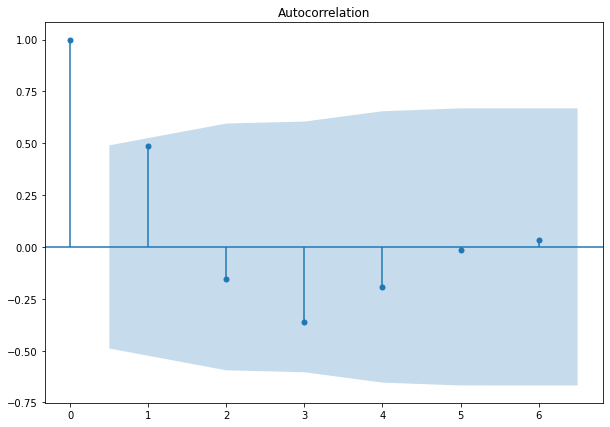

In [300]:
# model analyse autocorelation lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(train_data, lags=6)

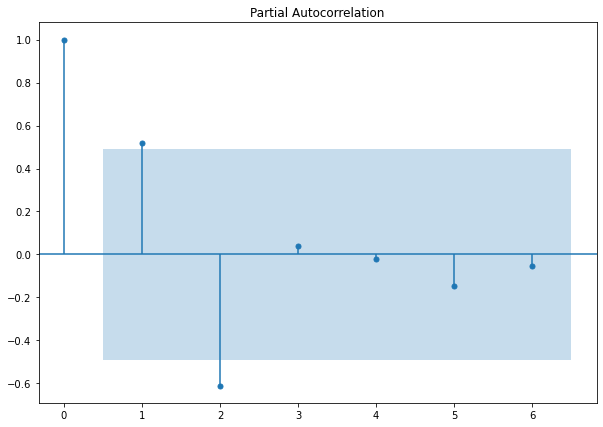

In [301]:
pacf_plt = plot_pacf(train_data, lags = 6)

In [321]:
# model and extract correlation coefficients
from statsmodels.tsa.ar_model import AutoReg
from time import time

start =time()
ar_mdl = AutoReg(train_data, lags =2).fit()
end = time()
print('Model training time:', end - start)
print(ar_mdl.summary())

# output explanations


Model training time: 0.0
                            AutoReg Model Results                             
Dep. Variable:            Customer ID   No. Observations:                    9
Model:                     AutoReg(2)   Log Likelihood                 -44.383
Method:               Conditional MLE   S.D. of innovations            137.214
Date:                Tue, 26 Jan 2021   AIC                             10.986
Time:                        03:18:43   BIC                             10.955
Sample:                    05-31-2011   HQIC                            10.604
                         - 11-30-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       -416.6684    447.202     -0.932      0.351   -1293.168     459.831
Customer ID.L1     0.9517      0.353      2.698      0.007       0.260       1.643
Customer ID

C:\Users\ndifr\anaconda3\envs\py37tf\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
